# Forecasting solar flares using random forest
***


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score, 
                             fbeta_score, recall_score, make_scorer)
#from imblearn.over_sampling import SMOTE

In [3]:
# Load raw dataframe
df = pd.read_csv("./Data/data_flares.csv")

print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DATE                        4480 non-null   object 
 1   USFLUX                      4480 non-null   float64
 2   MEANGAM                     4480 non-null   float64
 3   MEANGBT                     4480 non-null   float64
 4   MEANGBZ                     4480 non-null   float64
 5   MEANGBH                     4480 non-null   float64
 6   MEANJZD                     4480 non-null   float64
 7   TOTUSJZ                     4480 non-null   float64
 8   MEANALP                     4480 non-null   float64
 9   MEANJZH                     4480 non-null   float64
 10  TOTUSJH                     4480 non-null   float64
 11  ABSNJZH                     4480 non-null   float64
 12  SAVNCPP                     4480 non-null   float64
 13  MEANPOT                     4480 

# Changing the dataframe to fit random forest
***

In [4]:
# Ensure the 'DATE' column is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   DATE                        4480 non-null   datetime64[ns, UTC]
 1   USFLUX                      4480 non-null   float64            
 2   MEANGAM                     4480 non-null   float64            
 3   MEANGBT                     4480 non-null   float64            
 4   MEANGBZ                     4480 non-null   float64            
 5   MEANGBH                     4480 non-null   float64            
 6   MEANJZD                     4480 non-null   float64            
 7   TOTUSJZ                     4480 non-null   float64            
 8   MEANALP                     4480 non-null   float64            
 9   MEANJZH                     4480 non-null   float64            
 10  TOTUSJH                     4480 non-null   float64         

In [5]:
# Analyze flare distribution over time

# Number of C, M, and X flares per year
sum_columns = ['Flares: M', 'Flares: X']
df_flares = df.groupby(df['DATE'].dt.year)[sum_columns].agg(['sum'])
#df_flares = df_flares.reset_index()
print(df_flares)

# Number of days with M or X flares (count should be 365 or 366 for leap years)
yearly_flares = df.groupby(df['DATE'].dt.year)['flare_today'].agg(['sum', 'count'])
print("\nDays with M or X flare distribution by year:")
print(yearly_flares)

     Flares: M Flares: X
           sum       sum
DATE                    
2010       8.0       0.0
2011     111.0       8.0
2012     129.0       7.0
2013      99.0      12.0
2014     208.0      16.0
2015     125.0       2.0
2016      16.0       0.0
2017      39.0       4.0
2018       0.0       0.0
2019       0.0       0.0
2020       2.0       0.0
2021      28.0       2.0
2022     184.0       7.0
2023      23.0       3.0

Days with M or X flare distribution by year:
        sum  count
DATE              
2010    8.0    245
2011   65.0    365
2012   79.0    366
2013   68.0    365
2014  118.0    365
2015   68.0    365
2016   11.0    366
2017   15.0    365
2018    0.0    345
2019    0.0    273
2020    2.0    317
2021   21.0    365
2022   92.0    365
2023    8.0     13


In [6]:
# Function to create the lagged features to be used in the random forest model

def create_lagged_features(df, n_days=3):
    """
    Create features using the last n_days of data to predict tomorrow's flare.
    """
    df = df.copy()
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.sort_values('DATE').reset_index(drop=True)
    
    # Features to use (exclude DATE and target)
    feature_cols = [col for col in df.columns if col not in ['DATE', 'flare_today']]
    
    # Create lagged features for each of the past n_days
    lagged_df = pd.DataFrame(index=df.index) # important to keep the index for alignment
    
    for i in range(1, n_days + 1):
        for col in feature_cols:
            lagged_df[f'{col}_lag{i}'] = df[col].shift(i)
    
    # Target: tomorrow's flare (shift flare_today by -1)
    lagged_df['target'] = df['flare_today'].shift(-1)
    lagged_df['DATE'] = df['DATE']
    
    # Drop rows with NaN (first n_days rows and last row)
    lagged_df = lagged_df.dropna()
    
    return lagged_df

In [7]:
# Create the lagged features for the past 3 days
lagged_data = create_lagged_features(df, n_days=3)

print(lagged_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4476 entries, 3 to 4478
Data columns (total 95 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   USFLUX_lag1                      4476 non-null   float64            
 1   MEANGAM_lag1                     4476 non-null   float64            
 2   MEANGBT_lag1                     4476 non-null   float64            
 3   MEANGBZ_lag1                     4476 non-null   float64            
 4   MEANGBH_lag1                     4476 non-null   float64            
 5   MEANJZD_lag1                     4476 non-null   float64            
 6   TOTUSJZ_lag1                     4476 non-null   float64            
 7   MEANALP_lag1                     4476 non-null   float64            
 8   MEANJZH_lag1                     4476 non-null   float64            
 9   TOTUSJH_lag1                     4476 non-null   float64            
 10  ABSNJ

In [8]:
# chronological split is important for time series
lagged_data = lagged_data.sort_values('DATE').reset_index(drop=True)
assert lagged_data['DATE'].is_monotonic_increasing

print(lagged_data.head())

    USFLUX_lag1  MEANGAM_lag1  MEANGBT_lag1  MEANGBZ_lag1  MEANGBH_lag1  \
0  2.737004e+21     32.654695    114.207593    116.857353     50.317212   
1  3.460735e+21     29.845298    111.707230    113.253585     47.297438   
2  4.497098e+21     32.732238    114.995095    116.684410     53.376813   
3  3.672238e+21     31.230443    121.314292    122.012431     51.513595   
4  3.735080e+21     31.663927    119.169119    119.802653     50.661772   

   MEANJZD_lag1  TOTUSJZ_lag1  MEANALP_lag1  MEANJZH_lag1  TOTUSJH_lag1  ...  \
0      0.219577  3.095129e+12     -0.002852     -0.000701    147.333590  ...   
1      0.145063  3.903967e+12     -0.015477     -0.005461    192.675370  ...   
2      0.285346  5.270056e+12     -0.019851     -0.008012    271.850544  ...   
3      0.013373  4.616568e+12     -0.015028     -0.005155    234.575933  ...   
4      0.018493  4.679853e+12     -0.004378     -0.001769    219.506435  ...   

   Radio Flux 10.7cm_lag3  Sunspot Number_lag3  \
0                 

# Fitting the model
***

In [9]:
# Separate features and target
X = lagged_data.drop(['target', 'DATE'], axis=1)
y = lagged_data['target']

In [10]:
# Split into train and test sets

# Use last 20% as test set
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"Percentage of positive cases in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
print(y_test.value_counts())
print(f"Percentage of positive cases in test: {y_test.mean()*100:.2f}%")



Training samples: 3580
Test samples: 896

Class distribution in training set:
target
0.0    3147
1.0     433
Name: count, dtype: int64
Percentage of positive cases in train: 12.09%

Class distribution in test set:
target
0.0    774
1.0    122
Name: count, dtype: int64
Percentage of positive cases in test: 13.62%


In [11]:
# Apply SMOTE to balance the training data
#smote = SMOTE(random_state=42)
#X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

#print(f"\nAfter SMOTE:")
#print(f"Training samples: {len(X_train_balanced)}")
#print(pd.Series(y_train_balanced).value_counts())

In [12]:
# scoring metric
scoring = make_scorer(fbeta_score, beta=2)

In [13]:
# Define the pipeline
# GridSearchCV with balanced and umbalanced data
pipe = Pipeline([
    #('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))
])

param_grid = {
    'rf__n_estimators': [10, 50, 100],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 5],
    'rf__max_features': ['sqrt', 'log2', None]
}

In [14]:
# Use TimeSeriesSplit for cross-validation in time series data
tscv = TimeSeriesSplit(n_splits=5)

In [17]:
# you can just load the model if already trained and not run the grid search and best model again
# in that case, do not run the next two cells
best_rf = joblib.load("./Data/flares_best_RF.pkl")

In [16]:
# Search for the best hyperparameters
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring=scoring,
    n_jobs=-1,
    verbose=1
)

print("\nStarting grid search (this may take a while)...")
grid_search.fit(X_train, y_train)

print(f"\nBest hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Starting grid search (this may take a while)...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


KeyboardInterrupt: 

In [37]:
# Train final model with best parameters on balanced data
best_rf = grid_search.best_estimator_  # pipeline with scaler + best RF
best_rf.fit(X_train, y_train)
print(best_rf.named_steps['rf'])

# Save the best model
joblib.dump(best_rf, "./Data/flares_best_RF.pkl")
print("Best model saved to ./Data/flares_best_RF.pkl")

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=5, n_estimators=50, n_jobs=-1,
                       random_state=42)
Best model saved to ./Data/flares_best_RF.pkl


In [18]:
# Make predictions
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Results
***

In [19]:
# Evaluation
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

if len(np.unique(y_test)) > 1:
    f2_score = fbeta_score(y_test, y_pred, beta=2)
    f1_score = fbeta_score(y_test, y_pred, beta=1)
    recall = recall_score(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Average F2 Score: {f2_score:.4f}")
    print(f"Average F1 Score: {f1_score:.4f}")
    print(f"Average Recall Score: {recall:.4f}")
    print(f"Average Precision Score: {avg_precision:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")


Confusion Matrix:
[[710  64]
 [ 71  51]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91       774
         1.0       0.44      0.42      0.43       122

    accuracy                           0.85       896
   macro avg       0.68      0.67      0.67       896
weighted avg       0.85      0.85      0.85       896

Average F2 Score: 0.4229
Average F1 Score: 0.4304
Average Recall Score: 0.4180
Average Precision Score: 0.3972
ROC-AUC Score: 0.8239


In [21]:
# feature importances
importances = best_rf.steps[0][1].feature_importances_

# get feature names from X_train
feature_names = X_train.columns

# create a sorted table
import pandas as pd
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.steps[0][1].feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 30 Most Important Features:")
print(feature_importance.head(30))


Top 30 Most Important Features:
                            feature  importance
27                   Flares: C_lag1    0.100732
23           Radio Flux 10.7cm_lag1    0.061975
54           Radio Flux 10.7cm_lag2    0.048223
6                      TOTUSJZ_lag1    0.038194
85           Radio Flux 10.7cm_lag3    0.038024
22                   xrs_B_max_lag1    0.034514
58                   Flares: C_lag2    0.031593
24              Sunspot Number_lag1    0.031445
9                      TOTUSJH_lag1    0.030298
25  Sunspot Area (10^6 Hemis.)_lag1    0.027389
89                   Flares: C_lag3    0.024680
86              Sunspot Number_lag3    0.023575
87  Sunspot Area (10^6 Hemis.)_lag3    0.022022
55              Sunspot Number_lag2    0.019480
0                       USFLUX_lag1    0.017921
10                     ABSNJZH_lag1    0.016254
13                      TOTPOT_lag1    0.015822
11                     SAVNCPP_lag1    0.015356
44                      TOTPOT_lag2    0.014503
41     


Visualization saved as 'solar_flare_RF_results.png'


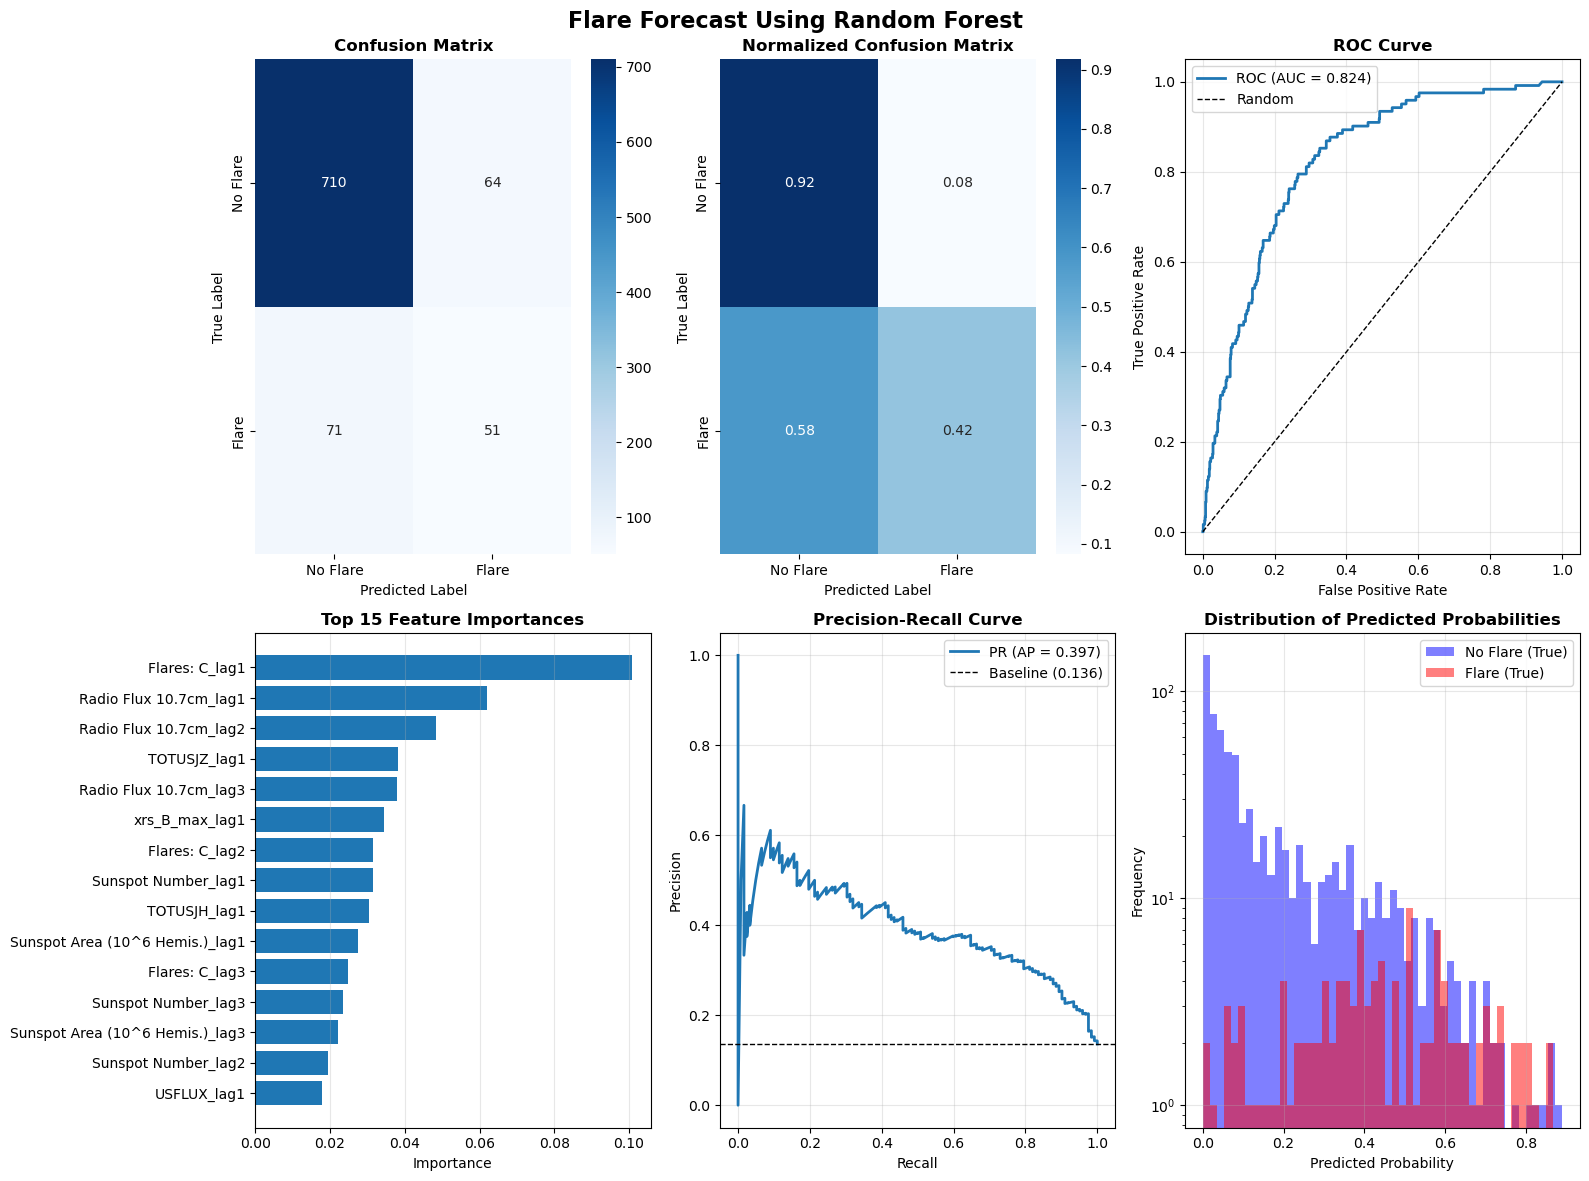

In [24]:
# Visualizations

fig = plt.figure(figsize=(16, 12))
plt.suptitle('Flare Forecast Using Random Forest', fontsize=16, fontweight='bold')

class_names = ['No Flare', 'Flare']

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=class_names, yticklabels=class_names)
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. Normalized Confusion Matrix
cm_norm = pd.DataFrame(cm).apply(lambda x: x/sum(x), axis = 1)
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues', ax=ax2, xticklabels=class_names, yticklabels=class_names)
ax2.set_title('Normalized Confusion Matrix', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. ROC Curve
if len(np.unique(y_test)) > 1:
    ax3 = plt.subplot(2, 3, 3)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax3.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC Curve', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Feature Importance (Top 15)
ax4 = plt.subplot(2, 3, 4)
top_features = feature_importance.head(15)
ax4.barh(range(len(top_features)), top_features['importance'])
ax4.set_yticks(range(len(top_features)))
ax4.set_yticklabels(top_features['feature'])
ax4.invert_yaxis()
ax4.set_xlabel('Importance')
ax4.set_title('Top 15 Feature Importances', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# 5. Precision-Recall Curve
if len(np.unique(y_test)) > 1:
    ax5 = plt.subplot(2, 3, 5)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax5.plot(recall, precision, linewidth=2, label=f'PR (AP = {avg_precision:.3f})')
    ax5.axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1, 
                label=f'Baseline ({y_test.mean():.3f})')
    ax5.set_xlabel('Recall')
    ax5.set_ylabel('Precision')
    ax5.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

# 6. Prediction Probability Distribution
ax6 = plt.subplot(2, 3, 6)
ax6.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, label='No Flare (True)', color='blue')
ax6.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Flare (True)', color='red')
ax6.set_xlabel('Predicted Probability')
ax6.set_ylabel('Frequency')
ax6.set_yscale('log')
ax6.set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./Figures/solar_flare_RF_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'solar_flare_RF_results.png'")
plt.show()

In [25]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm_thresh.ravel() if cm_thresh.size == 4 else (cm_thresh[0,0], 0, 0, 0)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\nThreshold = {thresh}")
    print(f"  TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}")


Threshold = 0.3
  TP: 93, FP: 189, TN: 585, FN: 29
  Precision: 0.330, Recall: 0.762

Threshold = 0.4
  TP: 69, FP: 119, TN: 655, FN: 53
  Precision: 0.367, Recall: 0.566

Threshold = 0.5
  TP: 51, FP: 64, TN: 710, FN: 71
  Precision: 0.443, Recall: 0.418

Threshold = 0.6
  TP: 27, FP: 32, TN: 742, FN: 95
  Precision: 0.458, Recall: 0.221

Threshold = 0.7
  TP: 16, FP: 14, TN: 760, FN: 106
  Precision: 0.533, Recall: 0.131
